In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/My Drive/BVIA Group 4/"
data_dir = root_dir + "Data/"
pickle_input_201516 = root_dir + "Pickle/201516_ret.pickle"
pickle_input_201213 = root_dir + "Pickle/201213_ret.pickle"
saved_models_dir = root_dir + "saved_models/"

# Week 5 - Optimization Models for Picking Loans

This notebook carries out the following steps
  1. Read the saved pickle data and prepares it for analysis and load the classification models for default probability and regression models for returns
  2. Uses them to implement the baseline strategies from last week
  3. Uses the predicted default probabilities and returns in an optimization model to pick a set of loans to invest in (You can compare the optimization based portfolios to the strategies from last week)
  4. Performs a sensitivity analysis of the performance of the loan portfolio by re-solving the optimization models for various levels of risk

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import plotly.express as px

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
## from gurobipy import *
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
#from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## 5.1 Load saved models.
Load the dictionary first, assign value when we need to.

In [ ]:
path = root_dir + "/saved_models/week4_saved_models"   
infile = open(path,'rb')
saved_models = pickle.load(infile)
models_to_save = saved_models.copy() # save new models in this new dict
infile.close()
print('models loaded:\n', saved_models.keys())

# save into a new dict if there is anything new to save
models_to_save = saved_models.copy()

models loaded:
 dict_keys(['ridge_clf07', 'gnb07', 'l1_logistic07', 'dt07', 'rf07', 'bt07', 'mlp07', 'gnb13', 'l1_logistic13', 'l2_logistic13', 'dt13', 'rf13', 'mlp13', 'l2_logistic07', 'reg_mlp15_df', 'reg_rf15', 'reg_mlp12', 'reg_rf12', 'reg_mlp12_df', 'reg_rf12_df', 'reg_mlp15', 'reg_rf15_df'])


## 5.2 Build and test baseline investment strategies
Now we test several investment strategies using the learning models above

In [ ]:
default_seed = 1
output_file = "output_sample"

In [ ]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order

    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb','ret_INTc','ret_Hybrid']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Regression':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Crystal-ball':

            # Sort the loans by realized return
            data_test = data_test.sort_values(by=ret_col, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Tree-based':
            # Define rules based on optimal tree nodes
            # FICO RANGE HIGH > 0.363 AND ANNUAL_INC > 0.448
            rule_1 = (data_test['fico_range_high'] > 0.363) & (data_test['annual_inc'] > 0.448) 
            # OR: FICO_RANGE_HIGH < 0.228 AND DTI < 0.358
            rule_2 = (data_test['fico_range_high'] < 0.228) & (data_test['dti'] < 0.358) 
            # Filter for loans to pick
            pf_test = data_test.loc[(rule_1) | (rule_2)]
            # Pick num_loans loans, if num_loans exceed available loans, return 'num_loans exceed loan availability'
            if num_loans <= len(pf_test):
              pf_test = pf_test.iloc[:num_loans]
              ret_test = np.mean(pf_test[ret_col])
            else:
              ret_test = 'num_loans exceed loan availability'
            # Returns
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}
            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )
            continue

        else:
            return 'Not a valid strategy'

    return out

In [ ]:
# 1. Load the data and engineer the features
## 1.1 Load data


# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open(pickle_input_201516, "rb" ) )
continuous_features = [i for i in continuous_features if i not in ['fico_range_low']]

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## 1.2 Prepare functions to fit and evaluate models

def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 20000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

## Implement the test strategies on 2015-16 data

In [ ]:
# ## read saved models
# reg_rf07 = saved_models['reg_rf07']
# rf07 = saved_models['rf07']

In [ ]:
# Read the data and features from the pickle
# data, discrete_features, continuous_features, ret_cols = pickle.load( open(pickle_input_201213, "rb" ) )

In [ ]:
final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
data_dict = prepare_data(feature_subset = final_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### \* 5.2.01 Choose saved models

Choose our saved model to use for the rest of the simulation.

In [ ]:
default_classifier = saved_models['l1_logistic07'].copy()

return_regressor = saved_models['reg_rf12'].copy()

return_regressor_separate = saved_models['reg_rf12_df'].copy()

print(return_regressor.keys())

dict_keys(['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc', 'ret_Hybrid'])


### \* 5.2.02 Reapply saved models

Because we downsampled data for training the default classifier, we need to reapply our models to obtain predictions on the dataset to be used for classification.

In [ ]:
def reapply_saved_model(data_dict, saved_model, separate=False):

    ## Params: 
    ## - data_dict: New data dictionary to run the saved model on
    ## - saved_model: Saved model to run

    ## Returns: A new "saved model" dictionary, with model the same, 
    ##  but with y_pred_labels and y_pred_probs updated for the whole dataset

    updated_model = saved_model.copy()

    ## TODO: Print prior and new accuracy to make sure model performance 
    ##  doesn't significantly worsen on this data

    if (separate==False):

      if "model" in updated_model.keys():
        ## Default classifier

        train_default = 0.43
        train_not_default = 0.57
        
        probs = updated_model['model'].predict_proba(data_dict['X_test'])[:,1]

        actual_default = sum(data_dict['y_test'])/len(data_dict['y_test'])
        actual_not_default = 1 - actual_default

        print("Adjusting classifier for new default split... New % Default:",actual_default)

        A = probs/(train_default/actual_default)
        B = (1 - probs)/(train_not_default/actual_not_default)
        new_p = A/(A+B)
        updated_model['y_pred_probs'] = new_p

        updated_model['y_pred_labels'] = data_dict['y_test']

      else:
        ## Single return regressor
        for ret_col in saved_model.keys():
          updated_model[ret_col]['predicted_return'] = updated_model[ret_col]['model'].predict(data_dict['X_test'])

    else:
      ## Separate return regressor
      for ret_col in saved_model.keys():
        updated_model[ret_col]['predicted_regular_return'] = updated_model[ret_col]['model_0'].predict(data_dict['X_test']) 
        updated_model[ret_col]['predicted_default_return'] = updated_model[ret_col]['model_1'].predict(data_dict['X_test']) 

    return updated_model

default_classifier = reapply_saved_model(data_dict, default_classifier)
return_regressor = reapply_saved_model(data_dict, return_regressor)
return_regressor_separate = reapply_saved_model(data_dict, return_regressor_separate, separate=True)

Adjusting classifier for new default split... New % Default: 0.1954


In [ ]:
strategy_results = {}

### 5.2.1 Random

In [ ]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb','ret_INTc','ret_Hybrid']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict,strategy = test_strategy, 
                            num_loans = 100, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy_results[test_strategy] = strat_random

strategy: Random
ret_PESS: 0.015218679214610141
ret_OPT: 0.04035024322004515
ret_INTa: 0.026266546427531578
ret_INTb: 0.04450320864556404
ret_INTc: 0.06643342937275866
ret_Hybrid: 0.07620388550175831


### 5.2.2 Ranking

In [ ]:
test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict, classifier=default_classifier, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy_results[test_strategy] = strat_rank

strategy: Ranking
ret_PESS: 0.01833118989096376
ret_OPT: 0.060569087486160314
ret_INTa: 0.02378788018544195
ret_INTb: 0.03273734918515122
ret_INTc: 0.0788164545172166
ret_Hybrid: 0.05254269406151706


### 5.2.3 Regression

In [ ]:
test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict, regressor=return_regressor, strategy = test_strategy, 
                        num_loans = 100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy_results[test_strategy] = strat_reg

strategy: Regression
ret_PESS: 0.027489564878988418
ret_OPT: 0.0499447055444742
ret_INTa: 0.01627417472374181
ret_INTb: 0.04886265792077707
ret_INTc: 0.07716630088394706
ret_Hybrid: 0.06450920106134957


### 5.2.4 Two-stage

In [ ]:
test_strategy = 'Two-stage'


print('strategy:',test_strategy)
two_stage = test_investments(data_dict, classifier = default_classifier, regressor = return_regressor_separate, 
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy_results[test_strategy] = two_stage

strategy: Two-stage
ret_PESS: 0.017395602006615773
ret_OPT: 0.0456615081530408
ret_INTa: 0.020106236004278674
ret_INTb: 0.038832659277333634
ret_INTc: 0.06767643777928976
ret_Hybrid: 0.057768382039832276


### 5.2.5 Tree-based

In [ ]:
test_strategy = 'Tree-based'

print('strategy: ', test_strategy)
tree_based = test_investments(data_dict, classifier = default_classifier,
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(tree_based[ret_col]['average return']))

strategy_results[test_strategy] = tree_based

strategy:  Tree-based
ret_PESS: 0.024539582083186313
ret_OPT: 0.04761878379037191
ret_INTa: 0.024784888683790064
ret_INTb: 0.04076961133486377
ret_INTc: 0.07005294680258964
ret_Hybrid: 0.06216501188699406


### 5.2.6 Best possible

In [ ]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb','ret_INTc','ret_Hybrid']
test_strategy = 'Crystal-ball'

print('strategy:',test_strategy)   
crystal_ball = test_investments(data_dict,strategy = test_strategy, 
                            num_loans = 100, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(crystal_ball[ret_col]['average return']))

strategy_results[test_strategy] = crystal_ball

strategy: Crystal-ball
ret_PESS: 0.13098190973034446
ret_OPT: 0.2792366568721941
ret_INTa: 0.1299409492935519
ret_INTb: 0.14860254346114335
ret_INTc: 0.1826553877634408
ret_Hybrid: 0.273218912099329


### \* Review Strategy results

In [ ]:
strategy_results_list = []
for s in strategy_results.keys():
  for ret_col in col_list:
    strategy_results_list.append([s, ret_col, (strategy_results[s][ret_col]['average return'])])
strategy_results_df = pd.DataFrame(strategy_results_list, columns=['Strategy','Return Column','Avg Return'])
strategy_results_df.sort_values(by=['Return Column','Strategy'], inplace=True)
print(strategy_results_df)

        Strategy Return Column  Avg Return
35  Crystal-ball    ret_Hybrid    0.273219
5         Random    ret_Hybrid    0.076204
11       Ranking    ret_Hybrid    0.052543
17    Regression    ret_Hybrid    0.064509
29    Tree-based    ret_Hybrid    0.062165
23     Two-stage    ret_Hybrid    0.057768
32  Crystal-ball      ret_INTa    0.129941
2         Random      ret_INTa    0.026267
8        Ranking      ret_INTa    0.023788
14    Regression      ret_INTa    0.016274
26    Tree-based      ret_INTa    0.024785
20     Two-stage      ret_INTa    0.020106
33  Crystal-ball      ret_INTb    0.148603
3         Random      ret_INTb    0.044503
9        Ranking      ret_INTb    0.032737
15    Regression      ret_INTb    0.048863
27    Tree-based      ret_INTb    0.040770
21     Two-stage      ret_INTb    0.038833
34  Crystal-ball      ret_INTc    0.182655
4         Random      ret_INTc    0.066433
10       Ranking      ret_INTc    0.078816
16    Regression      ret_INTc    0.077166
28    Tree-

In [ ]:
fig = px.bar(strategy_results_df, x="Return Column", y="Avg Return",
             color='Strategy', barmode='group',
             height=400,title="Strategy Results")
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

## 5.3 Optimization
 In this section, we implement three different optimization models. To illustrate and compare these models we will only use the M1-PESS definition and the predicted returns from the previously tested two-stage strategy.

In [ ]:
test_pool

NameError: ignored

### \* Write results to CSV for Optimization

CSV will be written to google drive root folder. The CSV will have the columns shown below, including variables like Grade which may not have been used in the models but are necessary for optimization.

In [ ]:
ret_col = 'ret_Hybrid'
strat = two_stage

print(strat[ret_col]['test data'].columns)

(strat[ret_col]['test data']).to_csv("./test_data.csv", index=False)

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util',
       'total_pymnt', 'last_pymnt_d', 'recoveries', 'loan_amnt_orig',
       'funded_amnt_orig', 'term_orig', 'int_rate_orig', 'installment_orig',
       'grade_orig', 'emp_length_orig', 'home_ownership_orig',
       'annual_inc_orig', 'verification_status_orig', 'issue_d_orig',
       'loan_status_orig', 'purpose_orig', 'dti_orig', 'delinq_2yrs_orig',
       'earliest_cr_line_orig', 'open_acc_orig', 'pub_rec_orig',
       'fico_range_high_orig', 'fico_range_low_orig', 'revol_bal_orig',
       'revol_util_orig', 'total_pymnt_orig', 'last_pymnt_d_orig',
       'recoveries_orig', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT',
       'ret_INTa'

## Three optimization models to picks loans

### 5.3.1 Directly maximize total profit
The LP will be writen into a separate file called "display.lp". 

In [ ]:
ret_col = 'ret_Hybrid'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 100

## first define cost vector
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]
    
#from docplex.mp.model import Model
#mdl = Model()

# variables
# select = mdl.binary_var_dict(Counties, name='select')
# isCovered = mdl.binary_var_dict(Counties, name='is covered')

In [ ]:
two_stage['ret_Hybrid']['test data']

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_amnt_orig,funded_amnt_orig,term_orig,int_rate_orig,installment_orig,grade_orig,emp_length_orig,home_ownership_orig,annual_inc_orig,verification_status_orig,issue_d_orig,loan_status_orig,purpose_orig,dti_orig,delinq_2yrs_orig,earliest_cr_line_orig,open_acc_orig,pub_rec_orig,fico_range_high_orig,fico_range_low_orig,revol_bal_orig,revol_util_orig,total_pymnt_orig,last_pymnt_d_orig,recoveries_orig,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,ret_Hybrid,outcome,cr_hist,train,score,predicted_regular_return,predicted_default_return,predicted_return_ret_PESS,predicted_return_ret_OPT,predicted_return_ret_INTa,predicted_return_ret_INTb,predicted_return_ret_INTc,predicted_return_ret_Hybrid
0,81357405,19200.0,19200.0,60 months,10.49,412.59,B,8 years,RENT,4.875067,Not Verified,2016-06-01,Charged Off,house,32.11,0.0,1999-10-01,1.146128,0.0,694.0,690.0,3.965954,32.7,3.798811,2016-12-01,3826.98,19200.0,19200.0,60 months,10.49,412.59,B,8 years,RENT,75000.0,Not Verified,2016-06-01,Charged Off,house,32.11,0.0,1999-10-01,13.0,0.0,694.0,690.0,9245.0,32.7,6291.330000,2016-12-01,3826.98,6.012444,60,-0.134465,-0.134465,-0.130764,-0.124823,-0.113791,-0.126522,True,200.020534,False,0.053930,0.110066,-0.048001,0.034333,0.064539,0.027833,0.046661,0.071787,0.101541
1,40361100,20000.0,20000.0,60 months,19.24,521.46,E,8 years,MORTGAGE,4.725176,Verified,2015-02-01,Charged Off,debt_consolidation,28.07,0.0,1992-09-01,1.230449,1.0,664.0,660.0,4.360461,91.7,4.335160,2018-05-01,1318.60,20000.0,20000.0,60 months,19.24,521.46,E,8 years,MORTGAGE,53109.0,Verified,2015-02-01,Charged Off,debt_consolidation,28.07,0.0,1992-09-01,16.0,1.0,664.0,660.0,22932.0,91.7,21634.160000,2018-05-01,1318.60,38.933038,60,0.016342,0.025184,0.024929,0.038499,0.063089,0.054605,True,269.015791,False,0.077749,0.111914,-0.035525,0.023722,0.072390,0.033819,0.049065,0.082530,0.100451
2,67337887,10000.0,10000.0,60 months,11.99,222.40,C,< 1 year,RENT,4.397957,Not Verified,2015-12-01,Fully Paid,credit_card,38.02,0.0,1998-04-01,1.113943,0.0,714.0,710.0,4.237393,78.9,4.124236,2020-08-01,0.00,10000.0,10000.0,60 months,11.99,222.40,C,< 1 year,RENT,25000.0,Not Verified,2015-12-01,Fully Paid,credit_card,38.02,0.0,1998-04-01,12.0,0.0,714.0,710.0,17273.0,78.9,13310.770000,2020-08-01,0.00,56.017577,60,0.066215,0.070923,0.074764,0.088228,0.112504,0.104145,False,212.012567,False,0.085064,0.112109,-0.035135,0.027322,0.076260,0.036778,0.057842,0.064947,0.099584
3,71755917,35000.0,35000.0,36 months,13.67,1190.62,C,None,RENT,4.982276,Verified,2016-02-01,Charged Off,credit_card,25.14,2.0,2000-08-01,1.176091,0.0,674.0,670.0,4.266725,34.2,4.362427,2016-10-01,13537.70,35000.0,35000.0,36 months,13.67,1190.62,C,None,RENT,96000.0,Verified,2016-02-01,Charged Off,credit_card,25.14,2.0,2000-08-01,14.0,0.0,674.0,670.0,18480.0,34.2,23036.080000,2016-10-01,13537.70,7.983737,36,-0.113942,-0.113942,-0.061140,-0.049567,-0.028135,-0.035593,True,186.024354,False,0.074356,0.110473,-0.045720,0.032501,0.072246,0.023993,0.052328,0.079176,0.098860
4,95089731,3475.0,3475.0,36 months,17.99,125.62,D,10+ years,MORTGAGE,4.778158,Not Verified,2016-12-01,Fully Paid,home_improvement,17.54,1.0,2006-12-01,1.146128,0.0,669.0,665.0,4.170144,37.4,3.626974,2018-06-01,0.00,3475.0,3475.0,36 months,17.99,125.62,D,10+ years,MORTGAGE,60000.0,Not Verified,2016-12-01,Fully Paid,home_improvement,17.54,1.0,2006-12-01,13.0,0.0,669.0,665.0,14795.0,37.4,4235.179435,2018-06-01,0.00,17.971622,36,0.072919,0.146068,0.056377,0.076541,0.113696,0.100792,False,120.018892,False,0.065605,0.108941,-0.046081,0.038975,0.073891,0.024542,0.040996,0.081723,0.098771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
import cplex

ret_col = 'ret_Hybrid'
test_pool = two_stage[ret_col]['test data']
num_var = c
num_loans = 100

## first define cost vector
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]

p = cplex.Cplex()

# Add the decision variables and set their lower bound and upper bound (if necessary)
p.variables.add(names=["x{0}".format(i) for i in range(num_var)]) # name them x0, x1, ..., xn

# Set the type of each variables
p.variables.set_types([i, p.variables.type.integer] for i in range(num_var)) # set all variables to be integral

# Add constr.
p.linear_constraints.add(lin_expr = [[list(range(num_var)), list(np.zeros(num_var)+1)]],
                         rhs = [num_loans],
                        names=["c{0}"]) # \sum_i x_i <= num_loans

# add objective
for i in range(num_var):
    p.objective.set_linear([(i, c[i])])
p.objective.set_sense(p.objective.sense.maximize)

p.write("display.lp") # write LP into a separate file

# Solve the model and print the answer
p.solve()
opt_sln_IP1  = np.array(p.solution.get_values())
print("OPT=", opt_sln_IP1)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 194958.835764 after 0.00 sec. (0.34 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 10000 columns.
All rows and columns eliminated.
Presolve time = 0.01 sec. (3.96 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (4.68 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (4.68 ticks)
OPT= [0. 0. 0. ... 0. 0. 0.]


In [ ]:
np.sum(opt_sln_IP1)

100.0

### Sanity check
Intuitively, assuming all entries are distinct, the optimal solution should be a vector with exactly one non-zero entry. Further, this entry should be the one where the cost vector attains maximum.

In [ ]:
argmax_opt = np.where(opt_sln_IP1==opt_sln_IP1.max()) # find argmax opt_sln
print("Number of nonzeros in OPT =",np.count_nonzero(opt_sln_IP1),". It's entry", argmax_opt[0][0])

argmax_c = np.where(c==c.max())
print("Maximum of the cost vector is attained at entry", argmax_c[0][0])

Number of nonzeros in OPT = 1 . It's entry 168
Maximum of the cost vector is attained at entry 168


### 5.3.2: Maximize profit with budget constraint

In [ ]:
m = cplex.Cplex()
num_var = test_pool.shape[0]
Budget = 10000

m.variables.add(names = ["x"+str(i) for i in range(num_var)])
m.variables.set_types([i, p.variables.type.binary] for i in range(num_var)) # set all variables to be integral

# add constraints
m.linear_constraints.add(lin_expr = [
                                    [list(range(num_var)), list(np.zeros(num_var)+1)], 
                                    [list(range(num_var)), list(np.zeros(num_var)+1)],
                                    [list(range(num_var)), test_pool[0:num_var].loan_amnt.tolist()]
                                    ],
                         rhs = [num_loans, 0, Budget], senses = ['L', 'G', 'L'],
                        names=["UB", "LB", "budget"]) 

# add objective
for i in range(num_var):
    m.objective.set_linear([(i, c[i])])
m.objective.set_sense(m.objective.sense.maximize)

m.write("display.lp") # write into a separate file

# Solve the model and print the answer
m.solve()
opt_sln_IP2 = np.array(m.solution.get_values())
print("OPT=", opt_sln_IP2)

argmax_opt = np.where(opt_sln_IP2==opt_sln_IP2.max()) # find argmax opt_sln
print("Number of one's:", len(argmax_opt[0]))

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.25 ticks)


Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 8555 columns.
MIP Presolve modified 210 coefficients.
Reduced MIP has 2 rows, 1445 columns, and 2890 nonzeros.
Reduced MIP has 1445 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (7.86 ticks)
Tried aggregator 1 time.
Reduced MIP has 2 rows, 1445 columns, and 2890 nonzeros.
Reduced MIP has 1445 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.76 ticks)
Probing time = 0.00 sec. (5.35 ticks)
Clique table members: 44.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (2.93 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000   414682.3737              --- 
*     0+    0                          995.8426   41

In [ ]:
argmax_opt[0]

array([ 0,  1,  2,  3,  4,  8, 10, 14, 27], dtype=int64)

### Sanity check
Intuitively the optimal solution $x^*$ should sequentially choose the highest return loans. We compare $x^*$ with opt_sln below.

In [ ]:
temp = np.sort(c)
temp = temp[::-1] # in descending order
cutoff = temp[901]
x = np.zeros(num_var)
for i in range(num_var):
    if cutoff<c[i]:
        x[i]=1
print("number of entries that differ:", int((x-opt_sln_IP2).sum()) )

number of entries that differ: 851


### 5.3.3: Maximize profit with risk-return tradeoff

In [ ]:
## First we need to train a clustering model to estimate the variance of return
n_clusters = 50
train_set = data_dict['train_set']
data_train = data.loc[train_set,:]

# Create a dataframe for testing, including the score
data_test = two_stage[ret_col]['test data']

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_dict['X_train'])
data_train['clusID'] = kmeans.predict(data_dict['X_train'])
data_test['clusID'] = kmeans.predict(data_dict['X_test'])
data_test['volatility'] = 0

for idx in range(n_clusters):
    std_clus = np.std(data_train[ret_col][data_train.clusID == idx])
    data_test.volatility[data_test.clusID == idx] = std_clus

## Specify the parameters of the optimization model
# beta: penalty factor on the risk
beta = 0.009
Budget = 10.7*1000000

In [ ]:
m = cplex.Cplex()
num_var = test_pool.shape[0]
Budget = 10*1000000

m.variables.add(names = ["x"+str(i) for i in range(num_var)])
m.variables.set_types([i, p.variables.type.binary] for i in range(num_var)) # set all variables to be binary

# add constraints
m.linear_constraints.add(lin_expr = [
                                    [list(range(num_var)), list(np.zeros(num_var)+1)], 
                                    [list(range(num_var)), list(np.zeros(num_var)+1)],
                                    [list(range(num_var)), test_pool[0:num_var].loan_amnt.tolist()]
                                    ],
                         rhs = [num_loans, 50, Budget], senses = ['L', 'G', 'L'],
                         names = ["UB", "LB", "budget"]) 

# add objective
for i in range(num_var):
    m.objective.set_linear([(i, (test_pool['predicted_return_'+  ret_col].iloc[i] -
                                beta * test_pool.volatility.iloc[i]) * test_pool.loan_amnt.iloc[i])])
    
m.objective.set_sense(m.objective.sense.maximize)

m.write("display_LP.lp") # write LP into a separate file

# Solve the model and print the answer
m.solve()
opt_sln_IP3 = np.array(m.solution.get_values())
print(opt_sln_IP3)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1


Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (18.76 ticks)
Found incumbent of value 68556.432810 after 0.03 sec. (23.42 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (12.10 ticks)
Probing time = 0.00 sec. (0.76 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.01 sec. (7.17 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        68556.4328   1.01270e+07              --- 
*     0+    0                       132262.7055   1.0

### 5.3.4 Visualization: violin plots for the expected returns of the above strategies

In [ ]:
test_pool['label'] = ['test_pool']*test_pool.shape[0]

# now we create a df for OPT of IP2
test_pool['chosen_IP2'] = opt_sln_IP2
df2 = test_pool[test_pool.chosen_IP2 == 1].copy() # df containing only rows chosen by IP2
test_pool = test_pool.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2 = df2.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2['label'] = ['IP2']*df2.shape[0]

# create a df for OPT of IP3
test_pool['chosen_IP3'] = opt_sln_IP3
df3 = test_pool[test_pool.chosen_IP3 == 1].copy() # df containing only rows chosen by IP3
test_pool = test_pool.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3 = df3.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3['label'] = ['IP3']*df3.shape[0]

# concatenate the dataframes
df_big = test_pool.append([df2,df3])

Text(0, 0.5, 'ret_PESS')

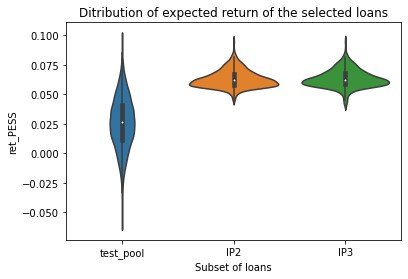

In [ ]:
ax = sns.violinplot(y=df_big["predicted_return_ret_PESS"], x=df_big["label"], 
                    data=df_big, order=['test_pool','IP2','IP3'])
ax.set_title("Ditribution of expected return of the selected loans")
ax.set_xlabel("Subset of loans")
ax.set_ylabel("ret_PESS")

## 5.4. Sensitivity analysis of the optimization solution by varying the budgets and the number of loans invested in
Build a trade-off curve between the beta value and the optimization objective (expected return). For this we loop through various values of beta from 0.1 through some large number in steps of 0.1 say. Then we create a plot of different pairs of means and stdevns of the expected return of the portfolios as you vary beta. The two axes will then be mean (return) and stdevn (risk).

In [ ]:
num_var = test_pool.shape[0]
Budget = 10*1000000
beta_min = 0.01
step = 0.1
num_beta = 10
table = np.zeros([num_beta,2]) # store the return and risk
for j in range(num_beta):
    beta = beta_min + j*step
    m = cplex.Cplex()
    m.variables.add(names = ["x"+str(i) for i in range(num_var)])
    m.variables.set_types([i, p.variables.type.binary] for i in range(num_var)) # set all variables to be binary

    # add constraints
    m.linear_constraints.add(lin_expr = [
                                        [list(range(num_var)), list(np.zeros(num_var)+1)], 
                                        [list(range(num_var)), list(np.zeros(num_var)+1)],
                                        [list(range(num_var)), test_pool[0:num_var].loan_amnt.tolist()]
                                        ],
                             rhs = [num_loans, 900, Budget], senses = ['L', 'G', 'L'],
                             names = ["UB", "LB", "budget"]) 

    # add objective
    for i in range(num_var):
        m.objective.set_linear([(i, (test_pool['predicted_return_'+  ret_col].iloc[i] -
                                    beta * test_pool.volatility.iloc[i]) * test_pool.loan_amnt.iloc[i])])

    m.objective.set_sense(m.objective.sense.maximize)
    m.solve() # Solve IP
    opt = np.array(m.solution.get_values())
    test_pool['chosen'] = opt
    df = test_pool[test_pool.chosen == 1]
    table[j,0] = df['predicted_return_'+  ret_col].sum()
    table[j,1] = df.volatility.sum()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1


Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (18.97 ticks)
Found incumbent of value -123771.089622 after 0.11 sec. (23.64 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (12.20 ticks)
Probing time = 0.03 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.13 sec. (18.67 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -123771.0896  3107918.8949              --- 
*     0+    0                        66623.4530  31

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.14 sec. (19.01 ticks)
Found incumbent of value -189954.162917 after 0.17 sec. (23.68 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (12.22 ticks)
Probing time = 0.03 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.06 sec. (9.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -189954.1629  2441456.4186              --- 
*     0+    0                        -2573.9240  244

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (19.06 ticks)
Found incumbent of value -256137.236212 after 0.13 sec. (23.73 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (12.25 ticks)
Probing time = 0.02 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (11.45 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -256137.2362  1840040.4369           818.38%
*     0+    0                       -71771.3010  18

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (19.13 ticks)
Found incumbent of value -322320.309507 after 0.11 sec. (23.79 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (12.28 ticks)
Probing time = 0.02 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.06 sec. (9.78 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -322320.3095  1326734.9197           511.62%
*     0+    0                      -140968.6781  132

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (19.19 ticks)
Found incumbent of value -388503.382802 after 0.13 sec. (23.86 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (12.31 ticks)
Probing time = 0.02 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.08 sec. (9.78 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -388503.3828   906152.7664           333.24%
*     0+    0                      -210166.0551   90

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (19.25 ticks)
Found incumbent of value -454686.456097 after 0.13 sec. (23.92 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (12.34 ticks)
Probing time = 0.02 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (10.43 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -454686.4561   585207.1653           228.71%
*     0+    0                      -279363.4321   5

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (19.30 ticks)
Found incumbent of value -520869.529391 after 0.13 sec. (23.97 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (12.37 ticks)
Probing time = 0.02 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (9.09 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -520869.5294   355560.3512           168.26%
*     0+    0                      -348560.8092   35

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.30 sec. (19.35 ticks)
Found incumbent of value -587052.602686 after 0.34 sec. (24.02 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (12.39 ticks)
Probing time = 0.05 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.08 sec. (10.60 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -587052.6027   199583.2262           134.00%
*     0+    0                      -417716.8842   1

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.14 sec. (19.38 ticks)
Found incumbent of value -653235.675981 after 0.17 sec. (24.05 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (12.41 ticks)
Probing time = 0.03 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.06 sec. (7.66 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -653235.6760   103840.8906           115.90%
*     0+    0                      -487112.9813   10

Tried aggregator 1 time.
MIP Presolve modified 1 coefficients.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.19 sec. (19.40 ticks)
Found incumbent of value -719418.749276 after 0.27 sec. (24.07 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 10000 columns, and 30000 nonzeros.
Reduced MIP has 10000 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.30 sec. (12.42 ticks)
Probing time = 0.06 sec. (0.91 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.13 sec. (7.10 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                      -719418.7493    48596.8096           106.76%
*     0+    0                      -564293.8702    4

### Visualization: Return vs Risk curve

Text(0, 0.5, 'risk')

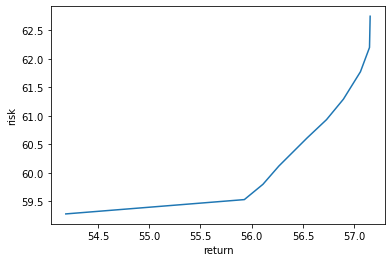

In [ ]:
plt.plot(table[:,0],table[:,1])
plt.xlabel("return")
plt.ylabel("risk")